# <font color='blue'>Introduction</font>

## <font color='green'>Foreword</font>

Christopher Denq

5/5/2023

Notebook 3 of 3

Contains modeling and conclusions for this NLP project.

My five main considerations for models are...
- linear regression, logistic regression
- neighbors, KNN
- ensemble (bagging), random forest
- ensemble (boosting), Adaboost
- stacking model

I decided to use log regression (despite normality violations) as a "baseline" model. I skipped KNN because that suffers tremendously from high-dimensionality data. I will also use random forest and the stacking model with the hopes that a linear regression model (tends to underfit) and a RF (tends to overfit) w a stacking model might balance out in the future. I forgo the boosting model due to computer processing power.

## <font color='green'>Problem Statement</font>

In the competitive and dynamic world of big data, data science teams are eager to leverage the internet's free data for insight.

This project aims to "pre-train" several NLP classification models and then provide an executive summary of the results to an existing data science client. This data science team is looking to accurately differentiate between two specific subreddits (AskReddit, AskScience) as a first step in developing targetted ads/recommendations.

Success of these pre-trained models will be based on balanced accuracy score because a "false positive" is not anymore problematic than a "false negative" in this business context. The scope of the project is limited to the data scrapped within 3 weeks on said subreddits. The model choices were limited by local compute power. The executive summary provides "future considerations" for the existing data science client, including mentions between score choice, model choice, and scope choice.

## <font color='green'>Code Setup</font>

### Imports

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report

# Note: see reddit_cleaning_eda for why this setting is here
pd.set_option('mode.chained_assignment', None)

### Global Custom Functions

In [155]:
# custom function for scoring
def score_me(model, X_train, y_train, X_test, y_test) -> None:
    """ 
    Print the balanced accuracy score for both training and testing.

    Parameters:
        model: sklearn.model
            The model on which the balanced accuracy scores are assessing

        X_train: np.array
            The x_training data to calculate scores

        y_train: pd.Series
            The y_training data to calculate scores

        X_test: np.array
            The x_testing data to calculate scores

        y_test: pd.Series
            The y_testing data to calculate scores

    Returns:
        None
    """ 
    y_pred_train = model.predict(X_train) 
    y_pred = model.predict(X_test)

    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    
    # training
    train_report = classification_report(y_train, y_pred_train, output_dict=True)
    train_bal_acc = balanced_accuracy_score(y_train, y_pred_train)
    train_prec = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_scores = [train_bal_acc, train_prec, train_recall, train_f1]

    # testing
    test_report = classification_report(y_test, y_pred, output_dict=True)
    test_bal_acc = balanced_accuracy_score(y_test, y_pred)
    test_prec = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)
    test_scores = [test_bal_acc, test_prec, test_recall, test_f1]

    # output labels
    labels = ["bal_acc", "prec", "recall", "f1"]

    # printing
    print(f"{model}")
    print(f"Training")
    for i in range(len(train_scores)):
        print(f"{labels[i]}: {train_scores[i]}")
    print(f"Testing")
    for i in range(len(train_scores)):
        print(f"{labels[i]}: {test_scores[i]}")
    print("-"*10)
    return (train_report, train_scores, test_report, test_scores)

In [156]:
# replacement for .head()
def peek(df: pd.DataFrame) -> None:
    """ 
    Print the top and bottom 3 values in a df.

    Parameters:
        df: pd.DataFrame
            The df to peek on

    Returns:
        None
    """ 
    print(df.iloc[np.r_[0:3, -3:0]])
    return

### Loading Dataset & Global Variables

In [183]:
# global variable: df of final scores
scores_df = pd.DataFrame(columns=["model", "bal_acc", "precision", "recall", "f1"]) #cvec
scores_2_df = pd.DataFrame(columns=["model", "bal_acc", "precision", "recall", "f1"]) #tfidf
scores_df

,model,bal_acc,precision,recall,f1


In [158]:
# importing data
df = pd.read_csv("../scrapped_data/clean_ask_data.csv")
print(df.shape)
peek(df)

(24697, 5)
       Unnamed: 0                                              title  \
0               0           whats the sluttiest thing a man can wear   
1               1  if my daughter wants to become a content creat...   
2               2  womens of reddit why do you care about zodiac ...   
24694       25460      why do we hear sounds that arent really there   
24695       25461  at what point in time could the average person...   
24696       25462  is it safe to drink very diluited strong acid ...   

        subreddit  char_count  word_count  
0       askreddit          40           8  
1       askreddit          68          15  
2       askreddit          51          10  
24694  askscience          45           9  
24695  askscience         130          21  
24696  askscience          55          10  


# <font color='blue'>Modeling</font>

## <font color='green'>Preprocessing</font>

### Data Cleaning

In [159]:
# dropping unused columns
df = df.loc[:, ["title", "subreddit"]]
peek(df)

                                                   title   subreddit
0               whats the sluttiest thing a man can wear   askreddit
1      if my daughter wants to become a content creat...   askreddit
2      womens of reddit why do you care about zodiac ...   askreddit
24694      why do we hear sounds that arent really there  askscience
24695  at what point in time could the average person...  askscience
24696  is it safe to drink very diluited strong acid ...  askscience


In [160]:
# mapping
df.loc[:, "subreddit"] = df.loc[:, "subreddit"].map({"askreddit": 1, "askscience": 0})
peek(df)

                                                   title  subreddit
0               whats the sluttiest thing a man can wear          1
1      if my daughter wants to become a content creat...          1
2      womens of reddit why do you care about zodiac ...          1
24694      why do we hear sounds that arent really there          0
24695  at what point in time could the average person...          0
24696  is it safe to drink very diluited strong acid ...          0


C:\Users\chris\AppData\Local\Temp\ipykernel_12520\4030240715.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "subreddit"] = df.loc[:, "subreddit"].map({"askreddit": 1, "askscience": 0})


### Train Test Split

In [161]:
X = df["title"]
y = df["subreddit"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Vectorize

In [162]:
# will be using 2 types of vectorizing and then applying models on both of them to determine best result
# generating stopwords
custom_words = ["what", "does", "how", "which", "whats", "did", "why", "where", "who", "when", "like"]
stop_words = ENGLISH_STOP_WORDS.union(custom_words) # these were determined from EDA

In [163]:
# Count Vectorizer
cvec_vect = CountVectorizer(stop_words=stop_words)
X_train_cvec_dense = np.asarray(cvec_vect.fit_transform(X_train).todense())
X_test_cvec_dense = np.asarray(cvec_vect.transform(X_test).todense())
# NOTE: applying np.asarray due to futurewarning

In [164]:
# Tfidf Vectorizer
tfidf_vect = TfidfVectorizer(stop_words=stop_words)
X_train_tfidf_dense = np.asarray(tfidf_vect.fit_transform(X_train).todense())
X_test_tfidf_dense = np.asarray(tfidf_vect.transform(X_test).todense())

In [165]:
# creating DataFrame versions to check
X_train_cvec_df = pd.DataFrame(X_train_cvec_dense, columns=cvec_vect.get_feature_names_out())
X_test_cvec_df = pd.DataFrame(X_test_cvec_dense, columns=cvec_vect.get_feature_names_out())

X_train_tfidf_df = pd.DataFrame(X_train_tfidf_dense, columns=tfidf_vect.get_feature_names_out())
X_test_tfidf_df = pd.DataFrame(X_test_tfidf_dense, columns=tfidf_vect.get_feature_names_out())

for i in [X_train_cvec_df, X_test_cvec_df, X_train_tfidf_df, X_test_tfidf_df]:
    print(i.shape)

(18522, 18413)
(6175, 18413)
(18522, 18413)
(6175, 18413)


### Standardize

In [166]:
# scaling Count Vectorizer
sc = StandardScaler()
Z_train_cvec = sc.fit_transform(X_train_cvec_dense) 
Z_test_cvec = sc.transform(X_test_cvec_dense)

In [167]:
# scaling Tfidf Vectorizer
sc = StandardScaler()
Z_train_tfidf = sc.fit_transform(X_train_tfidf_dense)
Z_test_tfidf = sc.transform(X_test_tfidf_dense)

## <font color='green'>Fitting on CVEC</font>

### Logistic Regression

c:\Users\chris\anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()
Training
bal_acc: 0.998203231495366
prec: 0.9980347538270583
recall: 0.9985511745834627
f1: 0.9982928974186539
Testing
bal_acc: 0.8179141461846944
prec: 0.8116578793204452
recall: 0.8549830299290343
f1: 0.8327573253193088
----------


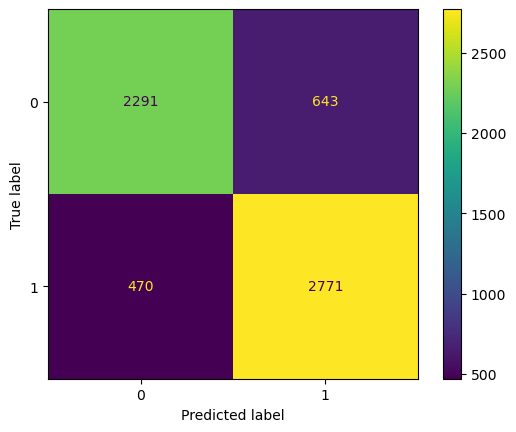

In [185]:
# instantiating model
logreg_model = LogisticRegression()

# fitting model
logreg_model.fit(Z_train_cvec, y_train)

# evaluation
train_report, train_scores, test_report, test_scores = score_me(logreg_model, Z_train_cvec, y_train, Z_test_cvec, y_test)

In [186]:
# inserting values into score_df
scores = [train_scores, test_scores]
scores_label = ["train", "test"]
for i in range(len(scores)):
    temp_dict = {scores_df.columns[1:][j]: [scores[i][j]] for j in range(len(scores[i]))}
    temp_dict["model"] = f"log_reg_{scores_label[i]}"
    temp_df = pd.DataFrame(temp_dict)
    scores_df = pd.concat([scores_df, temp_df])

### Random Forest (GridSearch)

In [172]:
# instantiating model
rf_model = RandomForestClassifier()
rf_params = {
    "n_estimators": [50, 100, 150],
    "max_depth": [1, 2, 3],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [2, 3, 5]
}
grid_rf_model = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_params,
    scoring="balanced_accuracy",
    cv=3,
    verbose=1
)

# fitting model
grid_rf_model.fit(Z_train_cvec, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
0.5455510717968305


In [175]:
# evaluation
print(grid_rf_model.best_params_)
print(grid_rf_model.best_score_)

{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
0.5455510717968305


### Random Forest (Optimal)

RandomForestClassifier(max_depth=3, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=50)
Training
bal_acc: 0.5353641735984562
prec: 0.5399843417962197
recall: 0.9992755872917314
f1: 0.7011072789980034
Testing
bal_acc: 0.5297330639490997
prec: 0.5401435486563179
recall: 0.9984572662758407
f1: 0.7010398613518198
----------


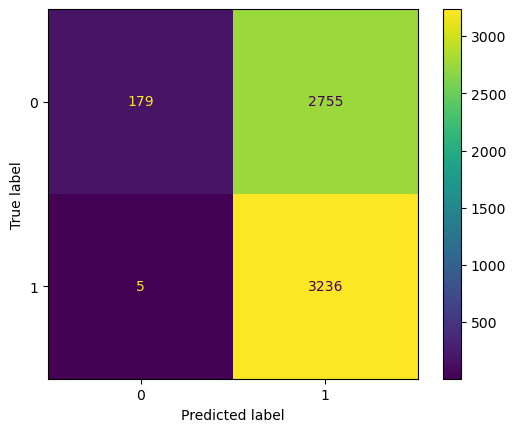

In [176]:
# instantiating model
rf_model = RandomForestClassifier(
    max_depth=3,
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=50
)

# fitting model
rf_model.fit(Z_train_cvec, y_train)

# evaluation
train_report, train_scores, test_report, test_scores = score_me(rf_model, Z_train_cvec, y_train, Z_test_cvec, y_test)

In [184]:
# inserting values into score_df
scores = [train_scores, test_scores]
scores_label = ["train", "test"]
for i in range(len(scores)):
    temp_dict = {scores_df.columns[1:][j]: [scores[i][j]] for j in range(len(scores[i]))}
    temp_dict["model"] = f"rf_{scores_label[i]}"
    temp_df = pd.DataFrame(temp_dict)
    scores_df = pd.concat([scores_df, temp_df])

,model,bal_acc,precision,recall,f1
0,rf_train,0.535364,0.539984,0.999276,0.701107
0,rf_test,0.529733,0.540144,0.998457,0.701040


### Stacking (w/ Decision Tree as Meta Learner)

c:\Users\chris\anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\chris\anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

RandomForestClassifier(max_depth=3, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=50)
Training
bal_acc: 0.5353641735984562
prec: 0.5399843417962197
recall: 0.9992755872917314
f1: 0.7011072789980034
Testing
bal_acc: 0.5297330639490997
prec: 0.5401435486563179
recall: 0.9984572662758407
f1: 0.7010398613518198
----------


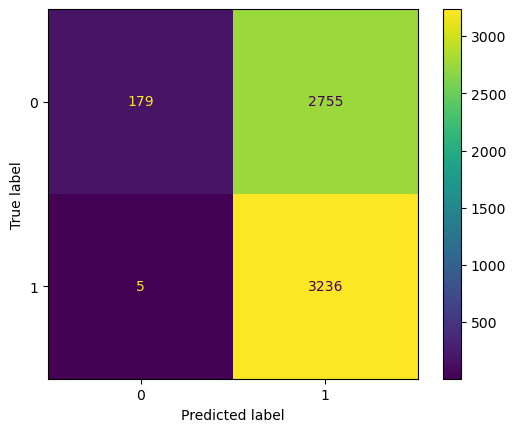

In [192]:
# instantiating model
estimators = [
    ('logreg', LogisticRegression()),
    ('rf', RandomForestClassifier(
        max_depth=3,
        min_samples_leaf=2,
        min_samples_split=5,
        n_estimators=50
    ))
]
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=DecisionTreeClassifier()
)

# fitting model
stacked_model.fit(Z_train_cvec, y_train)

# evaluation
train_report, train_scores, test_report, test_scores = score_me(rf_model, Z_train_cvec, y_train, Z_test_cvec, y_test)

In [193]:
# inserting values into score_df
scores = [train_scores, test_scores]
scores_label = ["train", "test"]
for i in range(len(scores)):
    temp_dict = {scores_df.columns[1:][j]: [scores[i][j]] for j in range(len(scores[i]))}
    temp_dict["model"] = f"stacking_{scores_label[i]}"
    temp_df = pd.DataFrame(temp_dict)
    scores_df = pd.concat([scores_df, temp_df])
scores_df

,model,bal_acc,precision,recall,f1
0,rf_train,0.535364,0.539984,0.999276,0.701107
0,rf_test,0.529733,0.540144,0.998457,0.701040
0,log_reg_train,0.998203,0.998035,0.998551,0.998293
0,log_reg_test,0.817914,0.811658,0.854983,0.832757
0,stacking_train,0.535364,0.539984,0.999276,0.701107
0,stacking_test,0.529733,0.540144,0.998457,0.701040


## <font color='green'>Fitting on TFIDF</font>

### Logistic Regression

c:\Users\chris\anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()
Training
bal_acc: 0.9986359656698957
prec: 0.9984484898634671
recall: 0.9989651247024733
f1: 0.9987067404686772
Testing
bal_acc: 0.8160933102564766
prec: 0.8147706968433591
recall: 0.8441838938599198
f1: 0.8292165479618124
----------


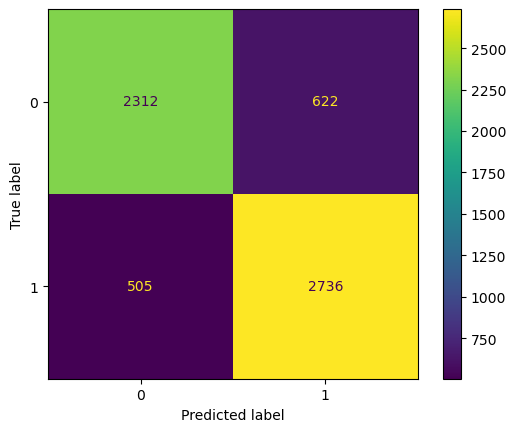

In [201]:
# instantiating model
logreg_model = LogisticRegression()

# fitting model
logreg_model.fit(Z_train_tfidf, y_train)

# evaluation
train_report, train_scores, test_report, test_scores = score_me(logreg_model, Z_train_tfidf, y_train, Z_test_tfidf, y_test)

In [202]:
# inserting values into score_df
scores = [train_scores, test_scores]
scores_label = ["train", "test"]
for i in range(len(scores)):
    temp_dict = {scores_df.columns[1:][j]: [scores[i][j]] for j in range(len(scores[i]))}
    temp_dict["model"] = f"log_reg_{scores_label[i]}"
    temp_df = pd.DataFrame(temp_dict)
    scores_2_df = pd.concat([scores_2_df, temp_df])
scores_2_df

,model,bal_acc,precision,recall,f1
0,log_reg_train,0.998636,0.998448,0.998965,0.998707
0,log_reg_test,0.816093,0.814771,0.844184,0.829217


### Random Forest (Optimal)

RandomForestClassifier(max_depth=3, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=50)
Training
bal_acc: 0.544859881634517
prec: 0.5452123136232213
recall: 0.9952395736313774
f1: 0.7044905135154934
Testing
bal_acc: 0.5424729737659549
prec: 0.547025927808846
recall: 0.995988892317186
f1: 0.7061912054255086
----------


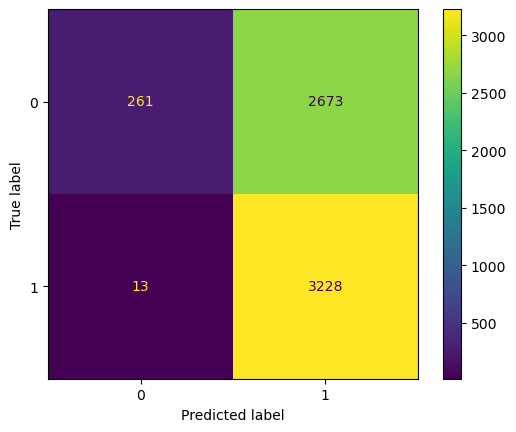

In [203]:
# instantiating model
rf_model = RandomForestClassifier(
    max_depth=3,
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=50
)

# fitting model
rf_model.fit(Z_train_tfidf, y_train)

# evaluation
train_report, train_scores, test_report, test_scores = score_me(rf_model, Z_train_tfidf, y_train, Z_test_tfidf, y_test)

In [204]:
# inserting values into score_df
scores = [train_scores, test_scores]
scores_label = ["train", "test"]
for i in range(len(scores)):
    temp_dict = {scores_df.columns[1:][j]: [scores[i][j]] for j in range(len(scores[i]))}
    temp_dict["model"] = f"rf_{scores_label[i]}"
    temp_df = pd.DataFrame(temp_dict)
    scores_2_df = pd.concat([scores_2_df, temp_df])
scores_2_df

,model,bal_acc,precision,recall,f1
0,log_reg_train,0.998636,0.998448,0.998965,0.998707
0,log_reg_test,0.816093,0.814771,0.844184,0.829217
0,rf_train,0.544860,0.545212,0.995240,0.704491
0,rf_test,0.542473,0.547026,0.995989,0.706191


### Stacking (w/ Decision Tree as Meta Learner)

c:\Users\chris\anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\chris\anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

RandomForestClassifier(max_depth=3, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=50)
Training
bal_acc: 0.544859881634517
prec: 0.5452123136232213
recall: 0.9952395736313774
f1: 0.7044905135154934
Testing
bal_acc: 0.5424729737659549
prec: 0.547025927808846
recall: 0.995988892317186
f1: 0.7061912054255086
----------


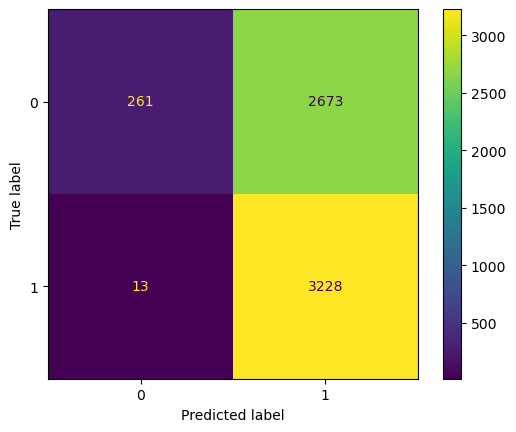

In [205]:
# instantiating model
estimators = [
    ('logreg', LogisticRegression()),
    ('rf', RandomForestClassifier(
        max_depth=3,
        min_samples_leaf=2,
        min_samples_split=5,
        n_estimators=50
    ))
]
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=DecisionTreeClassifier()
)

# fitting model
stacked_model.fit(Z_train_tfidf, y_train)

# evaluation
train_report, train_scores, test_report, test_scores = score_me(rf_model, Z_train_tfidf, y_train, Z_test_tfidf, y_test)

In [206]:
# inserting values into score_df
scores = [train_scores, test_scores]
scores_label = ["train", "test"]
for i in range(len(scores)):
    temp_dict = {scores_df.columns[1:][j]: [scores[i][j]] for j in range(len(scores[i]))}
    temp_dict["model"] = f"stacking_{scores_label[i]}"
    temp_df = pd.DataFrame(temp_dict)
    scores_2_df = pd.concat([scores_2_df, temp_df])
scores_2_df

,model,bal_acc,precision,recall,f1
0,log_reg_train,0.998636,0.998448,0.998965,0.998707
0,log_reg_test,0.816093,0.814771,0.844184,0.829217
0,rf_train,0.544860,0.545212,0.995240,0.704491
0,rf_test,0.542473,0.547026,0.995989,0.706191
0,stacking_train,0.544860,0.545212,0.995240,0.704491
0,stacking_test,0.542473,0.547026,0.995989,0.706191


## <font color='green'>Evaluating</font>

### Scores Recap

In [215]:
scores_df = scores_df.reset_index(drop=True)
scores_df

,model,bal_acc,precision,recall,f1
0,rf_train,0.535364,0.539984,0.999276,0.701107
1,rf_test,0.529733,0.540144,0.998457,0.701040
2,log_reg_train,0.998203,0.998035,0.998551,0.998293
3,log_reg_test,0.817914,0.811658,0.854983,0.832757
4,stacking_train,0.535364,0.539984,0.999276,0.701107
5,stacking_test,0.529733,0.540144,0.998457,0.701040


In [216]:
scores_2_df = scores_2_df.reset_index(drop=True)
scores_2_df

,model,bal_acc,precision,recall,f1
0,log_reg_train,0.998636,0.998448,0.998965,0.998707
1,log_reg_test,0.816093,0.814771,0.844184,0.829217
2,rf_train,0.544860,0.545212,0.995240,0.704491
3,rf_test,0.542473,0.547026,0.995989,0.706191
4,stacking_train,0.544860,0.545212,0.995240,0.704491
5,stacking_test,0.542473,0.547026,0.995989,0.706191


Foreword: the positive feature was "AskReddit" and the negative feature was "AskScience".

From the model results, we see that the logistic regression is actually the best model in both cases of the cvec and tfidf data.

Random forest is slightly overfit, but overall had very weak results when trying to predict the negative class (seen in the near perfect recall score but terrible precision score).

Logisitic regression was much more overfit, but when comparing the true pos/neg rates, it had a relatively equal performance both ways.

Due to the lower performance of the RF, the stacking model suffered in suit.

## <font color='green'>Supplementary Graphing</font>

In [225]:
# graphing results
cvec_data = scores_df.iloc[[1,3,5], :].reset_index(drop=True)
tfidf_data = scores_2_df.iloc[[1,3,5], :].reset_index(drop=True)

In [226]:
tfidf_data

,model,bal_acc,precision,recall,f1
0,log_reg_test,0.816093,0.814771,0.844184,0.829217
1,rf_test,0.542473,0.547026,0.995989,0.706191
2,stacking_test,0.542473,0.547026,0.995989,0.706191


In [227]:
cvec_data

,model,bal_acc,precision,recall,f1
0,log_reg_test,0.817914,0.811658,0.854983,0.832757
1,rf_test,0.529733,0.540144,0.998457,0.701040
2,stacking_test,0.529733,0.540144,0.998457,0.701040


Index(['bal_acc', 'precision', 'recall', 'f1'], dtype='object')

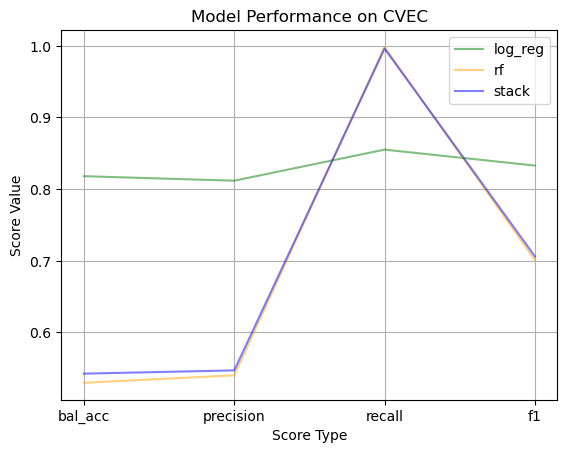

In [248]:
x = cvec_data.columns[1:]
plt.title("Model Performance on CVEC")
plt.xlabel("Score Type")
plt.ylabel("Score Value")
plt.grid(True)
plt.plot(x, cvec_data.iloc[0, 1:], alpha=0.5, label="log_reg", color="green")
plt.plot(x, cvec_data.iloc[1, 1:], alpha=0.5, label="rf", color="orange")
plt.plot(x, tfidf_data.iloc[2, 1:], alpha=0.5, label="stack", color="blue")
plt.legend()
plt.savefig("../images/model_performance.png")
plt.show()

# <font color='blue'>Conclusion</font>

## <font color='green'>Model Takeaways</font>

Ultimately, we will be evaluating based on the balanced accuracy because both classes are of equal importance (a false positive is not more dangerous than a false negative; a true positive is also just as important to get right as is the true negative). Based on these considerations, a balanced accuracy score is more important.

Aside on F1-score vs balanced accuracy: F1-scores is not a great capture of our true negatives rate, but as we had mentioned above, we care about getting true positives AND true negatives equally correct. Thus, the balanced accuracy wins against F1.

Thus, the models best for our data science clients is:
- Logistic Regression

These results will be included in the executive summary below.

## <font color='green'>Executive Summary</font>

### Takeaway
Via collaborating with this project, you (data science client) can kickstart your internal Subreddit project.

### Opportunity
Your team is interested in eventually launching targetted recommendations/ads to users on the AskScience and AskReddit subreddits. These channels have a combined over 14M subscribers, and even more internet foot traffic. However, given the scale of the posts and importance of the task, you need a rigorous classifier.

### Solution
This project provides multiple pre-trained models for you to pick form. Given your parameters (eg. both classes are equally important to be identified), the logistic model included in this project is the best fit for your business need. However, supplementary models are provided as well as a streamlined "launching point" for your team's future data science efforts.

### Benefits
This project saves your team money and hassle through a number of ways:
- data collection script created for any future data needs
- tedious data collection is done
- high-quality data cleaning is done
- pre-trained models (including its associated compute time) are done and provided
- out-of-box solution with strong classifier potential